# Session 5: Data structuring - aggregation and joining

In this combined teaching module and exercise set you will be working with how to aggregating and joining different datasets.

The exercises will continue the work with weather data we started working on in Exercise Set 4. We will also study a dataset of traffic data from Copenhagen to iterate through the pandas workflow once more. 

#### Packages
First load in the required modules and set up the plotting library:

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increases the plot size a little
mpl.rcParams['figure.figsize'] = 11, 6

%matplotlib inline 

### We are not done with pandas (yet!)
This is the final session on using pandas. We will cover the exciting methods for aggregation and working on parts of the data as well as combining different datasets. See the intro video and brief recap video below.

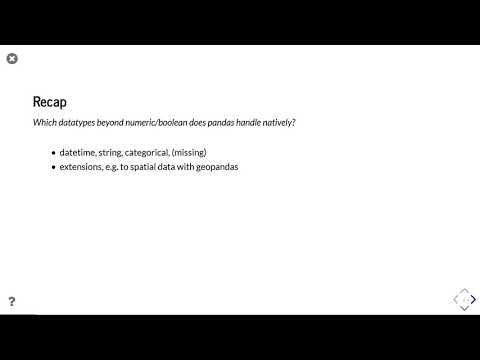

In [37]:
from IPython.display import YouTubeVideo
YouTubeVideo('KB_nSpQRPS8', width=640, height=360)

# Joining datasets
### How to combine two or more dataframes into one
Below we hear about how different datasets can be combined into one, by merging on overlapping information that exists in both datasets. If you want to know more then you can look up Chapter 8, section 8.2 in Python for Data Analysis, 2ed.

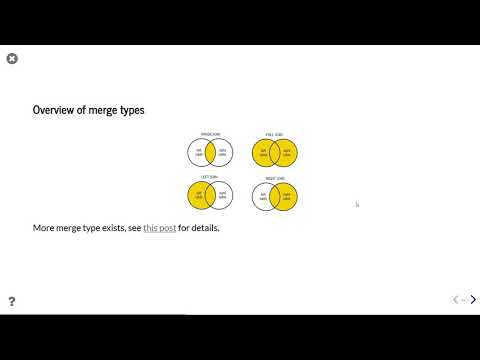

In [38]:
YouTubeVideo('JrCKDbmWGgM', width=640, height=360)

## Exercises on weather data - final part
We continue with the final part of three exercises on structuring weather data. Use the function for fetching and structuring weather data that you used in part 2 of this exercise (i.e. exercise section 4.1).



> **Ex. 5.1.1:** Get the processed data from years 1870-1875 as a list of DataFrames. Convert the list into a single DataFrame by concatenating vertically. 

In [39]:
#function from other module (from solution)

def load_weather(year):
    '''
    This functions loads the data for selected year and then structures and cleans it.
    - Structuring includes removing unused columns, renaming and selecting only observations 
    of maximum temperature. 
    - Cleaning includes inserting missing decimal, sorting and resetting index as well as
    processing temporal and spatial information.
    '''
        
    
    url = f"ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
    
    # loads the data
    df_weather = pd.read_csv(url, header=None)\
                    .iloc[:,:4] 
    
    # structure and clean data using methods chaining
    df_out = \
        df_weather\
            .rename(columns={0: 'station', 1: 'datetime', 2: 'obs_type', 3: 'obs_value'})\
            .query("obs_type == 'TMAX'")\
            .assign(obs_value=lambda df: df['obs_value']/10)\
            .sort_values(by=['station', 'datetime'])\
            .reset_index(drop=True)\
            .copy() 
    
    # area process
    df_out['area'] = df_out['station'].str[0:2]
    
    # datetime process
    df_out['datetime_dt'] = pd.to_datetime(df_out['datetime'], format = '%Y%m%d')
    df_out['month'] = df_out['datetime_dt'].dt.month
    
    return df_out

In [40]:
#Ex. 5.1.1: Get the processed data from years 1870-1875 as a list of DataFrames. 
# Convert the list into a single DataFrame by concatenating vertically.

data_list = []

for y in range(1870,1876):
    year_data = load_weather(y)
    data_list.append(year_data)

weather_data = pd.concat(data_list) #specify axis=0??

# Split-apply-combine
### A framework for processing data in parts
Often we need to process information for a given individual, point in time etc. Instead of writing a loop over all the subsets of the data, we can use a more clever approach. Below we introduce the split-apply-combine framework and show how we can leverage it in pandas. If you want to know more then you can look up Chapter 10 in Python for Data Analysis, 2ed.

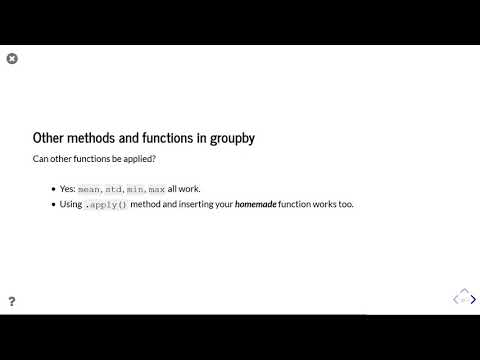

In [14]:
YouTubeVideo('khSWRMPqATQ', width=640, height=360)

> **Ex. 5.1.2:** Compute the mean maximum daily temperature for each month-year pair. 

In [41]:
#year
weather_data['year'] = weather_data['datetime_dt'].dt.year
#month-year
weather_data['month_year'] = weather_data['datetime_dt'].apply(lambda x: x.strftime('%m-%Y'))
print(weather_data['station'])

0        ASN00063004
1        ASN00063004
2        ASN00063004
3        ASN00063004
4        ASN00063004
            ...     
32030    USW00094728
32031    USW00094728
32032    USW00094728
32033    USW00094728
32034    USW00094728
Name: station, Length: 132317, dtype: object


In [26]:
#maximum daily temperature is TMAX, so we use obs_value
split_vars = ['year','month']
combined = weather_data.groupby(split_vars)['obs_value'].agg('mean')

print(combined)

#could also do a for loop as in video

year  month
1870  1         6.237698
      2         5.341376
      3         7.628285
      4        15.563050
      5        19.785612
                 ...    
1875  8        23.911261
      9        19.877832
      10       13.649564
      11        6.860328
      12        5.001091
Name: obs_value, Length: 72, dtype: float64


> **Ex. 5.1.3:** Plot the monthly max,min, mean, first and third quartiles for maximum temperature for our station with the ID _'ITE00100550'_ for the years 1870-1875. 

> *Hint*: the method `describe` computes all these measures.

In [42]:
import seaborn as sns
weather_station = weather_data.loc[(weather_data['station']=='ITE00100550')]

combined = weather_station.groupby(split_vars)['obs_value'].describe()

# plot
combined.plot(y=["max", "min", "mean", "25%","75%"], x=['year'], kind="line",figsize=(10,6))

#DOES NOT WORK!


KeyError: "None of [Index(['year'], dtype='object')] are in the [columns]"

> **Ex. 5.1.4:** Parse the station location data which you can find at https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt. Merge station locations onto the weather data spanning 1870-1875.  

> _Hint:_ The location data have the folllowing format, 

```
------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
------------------------------
```

> *Hint*: The station information has fixed width format - does there exist a pandas reader for that?

In [43]:
#specify url
url = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

#load location data columns and rename
loc_data = pd\
        .read_fwf(url, header=None)\
        .iloc[:,:4]\
        .rename(columns={0:'station', 1:'LATITUDE', 2:'LONGITUDE', 3:'ELEVATION',4:'NAME'}) 
#loc_data

#merge all observations from weather_data, only matching obs from location data
merged_data = pd.merge(weather_data, loc_data, on='station', how='left')
merged_data

,station,datetime,obs_type,obs_value,area,datetime_dt,month,year,month_year,LATITUDE,LONGITUDE,ELEVATION
0,ASN00063004,18700809,TMAX,10.0,AS,1870-08-09,8,1870,08-1870,33.4167,149.5500,704.0
1,ASN00063004,18700810,TMAX,8.9,AS,1870-08-10,8,1870,08-1870,33.4167,149.5500,704.0
2,ASN00063004,18700811,TMAX,15.6,AS,1870-08-11,8,1870,08-1870,33.4167,149.5500,704.0
3,ASN00063004,18700812,TMAX,16.7,AS,1870-08-12,8,1870,08-1870,33.4167,149.5500,704.0
4,ASN00063004,18700813,TMAX,16.7,AS,1870-08-13,8,1870,08-1870,33.4167,149.5500,704.0
...,...,...,...,...,...,...,...,...,...,...,...,...
132312,USW00094728,18751227,TMAX,10.6,US,1875-12-27,12,1875,12-1875,40.7789,-73.9692,39.6
132313,USW00094728,18751228,TMAX,1.1,US,1875-12-28,12,1875,12-1875,40.7789,-73.9692,39.6
132314,USW00094728,18751229,TMAX,2.8,US,1875-12-29,12,1875,12-1875,40.7789,-73.9692,39.6
132315,USW00094728,18751230,TMAX,6.7,US,1875-12-30,12,1875,12-1875,40.7789,-73.9692,39.6


# Reshaping  dataframes

Often we have data that comes in a format that does not fit our purpose. If you want to know more then you can look up Chapter 8, section 8.3 in Python for Data Analysis, 2ed.

In [ ]:
YouTubeVideo('kJO85WOXNEU', width=640, height=360)

> **Ex. 5.1.5:** For which months was the temperature in general colder in 1870 vs. 1875?

> *Hint: you may use `unstack`.


In [ ]:
# all months, except august, were colder:
tmax_1870 = tmax_mean.unstack(level=1).loc[1870]
tmax_1875 = tmax_mean.unstack(level=1).loc[1875]
print('Months where temperature was not colder:', tmax_1875[tmax_1875-tmax_1870>=0].index.tolist())


#does not work!

# Summary and beyond pandas

We round off this lecture with a brief summary of the most important points. I also review some packages that you can look at, which allows you to scale up your data analysis.

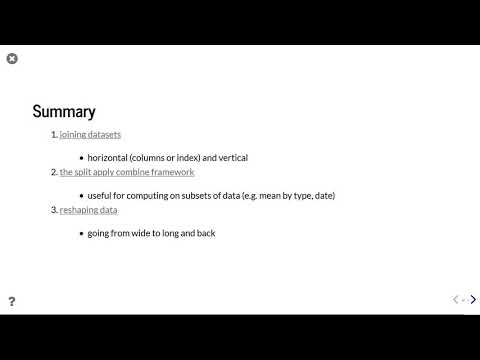

In [44]:
YouTubeVideo('CKg3MjnhVlg', width=640, height=360)

## More practice: Traffic data in Copenhagen

In this second part set of exercises you will be working with traffic data from Copenhagen Municipality.

The municipality have made the data openly available through the [opendata.dk](http://www.opendata.dk/) platform. We will use the data from traffic counters to construct a dataset of hourly traffic. We will use this data to get basic insights on the development in traffic over time and relate it to weather. The gist here is to practice a very important skill in Data Science: being able to quickly fetch data from the web and structure it so that you can work with it. Scraping usually gets a bit more advanced than what we will do today, but the following exercises should give you a taste for how it works. The bulk of these exercise, however, revolve around using the Pandas library to structure and analyze data.

### Part 5.2.a: getting some data to work with

Hence follows a simple scraping exercise where you (1) collect urls for datasets in the webpage listing data on traffic counters and (2) use these urls to load the data into one dataframe.

> **Ex. 5.2.1:** Using the requests module, extract the html markup of the webpage data.kk.dk/dataset/faste-trafiktaellinger and store it as a string in a new variable.

In [12]:
# [Answer to Ex. 5.2.1]

> **Ex. 5.2.2:** Using the re module, extract a list of all the urls in the html string and store them in a new variable.

> _Hint:_ Try using the re.findall method. You may want to Google around to figure out how to do this. Searching for something along the lines of "extract all links in html regex python" and hitting the first StackOverflow link will probably get you farther than reading elaborate documentation.

In [14]:
# [Answer to Ex. 5.2.2]

> **Ex. 5.2.3:** Create a new variable that only contains the links that point to downloadable traffic data sheets. 

> _Hint:_ You want to filter the results from above. For example to only include urls with the term 'download' in them.

In [16]:
# [Answer to Ex. 5.2.3]

> **Ex. 5.2.4:** Using pd.read_excel method, load the datasets into a list. Your resulting variable should hold a list of Pandas dataframes.

> _Hint:_ you may want to set the `skiprows` keyword argument. 

In [18]:
# [Answer to Ex. 5.2.4]

> **Ex. 5.2.5:** Merge the list of dataframes into a single dataframe.

In [20]:
# [Answer to Ex. 5.2.5]

### Part 5.2.b Structuring your data

If you successfully completed the previous part, you should now have a dataframe with about 183.397 rows (if your number of rows is close but not the same, worry not—it matters little in the following). Well done! But the data is still in no shape for analysis, so we must clean it up a little.

161.236 rows (and 30 columns) is a lot of data. ~3.3 MB by my back-of-the-envelope calculations, so not "Big Data", but still enough to make your CPU heat up if you don't use it carefully. Pandas is built to handle fairly large dataframes and has advanced functionality to perform very fast operations even when the size of your data grows huge. So instead of working with basic Python we recommend working pandas built-in procedures as they are constructed to be fast on dataframes.

Nerd fact: the reason pandas is much faster than pure Python is that dataframes access a lower level programming languages (namely C, C++) which are multiple times faster than Python. The reason it is faster is that it has a higher level of explicitness and thus is more difficult to learn and navigate.

> **Ex. 5.2.6:** Reset the row indices of your dataframe so the first index is 0 and the last is whatever the number of rows your dataframe has. Also drop the column named 'index' and the one named `Spor`.

In [22]:
# [Answer to Ex. 5.2.6]

> **Ex. 5.2.7:** Rename variables from Danish to English using the dictionary below.

```python 
dk_to_uk = {
    'Vejnavn':'road_name',
    '(UTM32)':'UTM32_north',
    '(UTM32).1':'UTM32_east',
    'Dato':'date',
    'Vej-Id':'road_id'
}
```

In [24]:
# [Answer to Ex. 5.2.7]

Python is quite efficient. For example, when you create a new dataframe by manipulating an old one, Python notices that—apart from some minor changes—these two objects are almost the same. Since memory is a precious resource, Python will represent the values in the new dataframe as references to the variables in the old dataset. This is great for performance, but if you for whatever reason change some of the values in your old dataframe, values in the new one will also change—and we don't want that! Luckily, we can break this dependency.

> **Ex. 5.2.8:** Break the dependencies of the dataframe that resulted from Ex. 5.2.7 using the `.copy` method. Delete all other dataframes.

In [26]:
# [Answer to Ex. 5.2.8]

Once you have structured appropriately, something that you will want to do again and again is selecting subsets of the data. Specifically, it means that you select specific rows in the dataset based on some column values.

>**Ex. 5.2.9:** Create a new column in the dataframe called total that is True when the last letter of road_id is T and otherwise False.

> _Hint:_ you will need the `pd.Series.str` attribute for this.

In [28]:
# [Answer to Ex. 5.2.9]

> **Ex. 5.2.10:** Select rows where total is True. Delete all the remaining observations.

In [30]:
# [Answer to Ex. 5.2.10]

> **Ex. 5.2.11:** Make two datasets based on the lists of columns below. Call the dataset with spatial columns data_geo and the other data.

```python
# Columns for `geo_data`, stored in `geo_columns`
spatial_columns = ['road_name', 'UTM32_north', 'UTM32_east']

# Columns for `data`, stored in `select_columns`
hours = ['kl.{}-{}'.format(str(h).zfill(2), str(h+1).zfill(2)) for h in range(24)]
select_columns = ['road_name', 'date'] + hours
```

In [32]:
# [Answer to Ex. 5.2.11]

> **Ex. 5.2.12:** Drop the duplicate rows in data_geo.

In [34]:
# [Answer to Ex. 5.2.12]

**Formatting: wide and narrow format**

When talking about two-dimensional data (matrices, tables or dataframes, we can call it many things), we can either say that it is in wide or long format (see explanation here, "wide" and "long" are used interchangably). In Pandas we can use the commands stack and unstack to move between these formats.

The wide format has the advantage that it often requires less storage and is easier to read when printed. On the other hand the long format can be easier for modelling, because each observation has its own row. Turns out that the latter is what we most often need.

> **Ex. 5.2.13:** Turn the dataset from wide to long so hourly data is now vertically stacked. Store this dataset in a dataframe called data. Name the column with hourly information hour_period. Your resulting dataframe should look something like this.

> _Hint:_ pandas' melt function may be of use.

In [36]:
# [Answer to Ex. 5.2.13]

**Categorical data**

Categorical data can contain Python objects, usually strings. These are smart if you have variables with string observations that are long and often repeated, e.g. with road names.

> **Ex. 5.2.14:** Use the `.astype` method to convert the type of the road_name column to categorical.

In [38]:
# [Answer to Ex. 5.2.14]

### Structure temporal data

Pandas has native support for working with temporal data. This is handy as much 'big data' often has time stamps which we can make Pandas aware of. Once we have encoded temporal data it can be used to extract information such as the hour, second etc.

> **Ex. 5.2.15:** Create a new column called hour which contains the hour-of-day for each row. 

In [40]:
# [Answer to Ex. 5.2.15]

>**Ex. 5.2.16:** Create a new column called time, that contains the time of the row in datetime format. Delete the old temporal columns (hour, hour_period, date) to save memory.

> _Hint:_ try making an intermediary series of strings that has all temporal information for the row; then use pandas to_datetime function where you can specify the format of the date string.

In [42]:
# [Answer to Ex. 5.2.16]

> **Ex. 5.2.17:** Using your time column make a new column called weekday which stores the weekday (in values between 0 and 6) of the corresponding datetime.

> _Hint:_ try using the dt method for the series called time; dt has some relevant methods itself.

In [44]:
# [Answer to Ex. 5.2.17]

### Statistical descriptions of traffic data

> **Ex. 5.2.18:** Print the "descriptive statistics" of the traffic column. Also show a kernel density estimate of the values.

> _Hint:_ Use the describe method of pandas dataframes for the first task. Use seaborn for the second. 

In [46]:
# [Answer to Ex. 5.2.18]

> **Ex. 5.2.19:** Which road has the most average traffic?

In [48]:
# [Answer to Ex. 5.2.19]

> **Ex. 5.2.20:** Compute annual, average road traffic during day hours (9-17). Which station had the least traffic in 2013? Which station has seen highest growth in traffic from 2013 to 2014?

In [50]:
# [Answer to Ex. 5.2.20]